In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import h5py, os

import numpy as np
import healpy as hp
import matplotlib.pyplot as plt

from tqdm import tqdm

from msfm.grid_pipeline import GridPipeline
from msfm.utils import logger, input_output, files, scales, power_spectra, parameters, clustering, redshift

In [3]:
conf = "/global/homes/a/athomsen/multiprobe-simulation-forward-model/configs/v10/linear_bias.yaml"
conf = files.load_config(conf)
hp_datapath = "/global/u2/a/athomsen/multiprobe-simulation-forward-model/data/healpy_data"

n_side = conf["analysis"]["n_side"]
n_pix = conf["analysis"]["n_pix"]
l_min_global = 20
l_max_global = 1535
data_vec_pix, patches_pix_dict, corresponding_pix_dict, _ = files.load_pixel_file(conf)

# fiducial values
Aia = conf["analysis"]["fiducial"]["Aia"]
n_Aia = conf["analysis"]["fiducial"]["n_Aia"]

bg = conf["analysis"]["fiducial"]["bg"]
n_bg = conf["analysis"]["fiducial"]["n_bg"]

z0 = conf["analysis"]["modelling"]["z0"]

# metacal
metacal_bins = conf["survey"]["metacal"]["z_bins"]
n_z_metacal = len(metacal_bins)
tomo_z_metacal, tomo_nz_metacal = files.load_redshift_distributions("metacal", conf)
tomo_Aia = redshift.get_tomo_amplitudes(Aia, n_Aia, tomo_z_metacal, tomo_nz_metacal, z0)

# maglim
maglim_bins = conf["survey"]["metacal"]["z_bins"]
n_z_maglim = len(maglim_bins)
tomo_z_maglim, tomo_nz_maglim = files.load_redshift_distributions("maglim", conf)
tomo_n_gal_maglim = np.array(conf["survey"]["maglim"]["n_gal"]) * hp.nside2pixarea(n_side, degrees=True)
tomo_bg = redshift.get_tomo_amplitudes(bg, n_bg, tomo_z_maglim, tomo_nz_maglim, z0)

n_z = n_z_metacal + n_z_maglim

# numpy
rng = np.random.default_rng(12)

24-09-25 03:10:48     files.py INF   Loaded the pixel file /global/u2/a/athomsen/multiprobe-simulation-forward-model/data/DESY3_pixels_v11_fiducial_512.h5 


# full sky

In [4]:
%%time
# fidu_dir = "/global/cfs/cdirs/des/cosmogrid/v11desy3/fiducial/cosmo_fiducial"
# fidu_dir = "/pscratch/sd/a/athomsen/v11desy3/fiducial/cosmo_fiducial"
fidu_dir = "/global/cfs/cdirs/des/cosmogrid/v11desy3/CosmoGrid/v11desy3/fiducial/cosmo_fiducial"

n_examples = 1

wl = []
gc = []
for i in tqdm(range(n_examples)):
    with h5py.File(os.path.join(fidu_dir, f"perm_{i:04d}", "projected_probes_maps_v11dmb.h5"), "r") as f:
        kg = []
        ia = []
        for z_bin in metacal_bins:
            kg.append(hp.ud_grade(f[f"map/kg/{z_bin}"], n_side))
            ia.append(hp.ud_grade(f[f"map/ia/{z_bin}"], n_side))
        kg = np.stack(kg, axis=-1)
        ia = np.stack(ia, axis=-1)
        
        wl.append(kg + tomo_Aia * ia)

        dg = []
        for z_bin in maglim_bins:
            dg.append(hp.ud_grade(f[f"map/dg/{z_bin}"], n_side))
        dg = np.stack(dg, axis=-1)
        
        gc.append(clustering.galaxy_density_to_count(tomo_n_gal_maglim, (dg - np.mean(dg))/np.mean(dg), tomo_bg, nest=False))

wl = np.stack(wl, axis=0)
gc = np.stack(gc, axis=0)

fidu_maps = np.concatenate([wl, gc], axis=-1)

print(fidu_maps.shape)

100%|██████████| 1/1 [01:02<00:00, 62.77s/it]

(1, 3145728, 8)
CPU times: user 53 s, sys: 9.84 s, total: 1min 2s
Wall time: 1min 2s


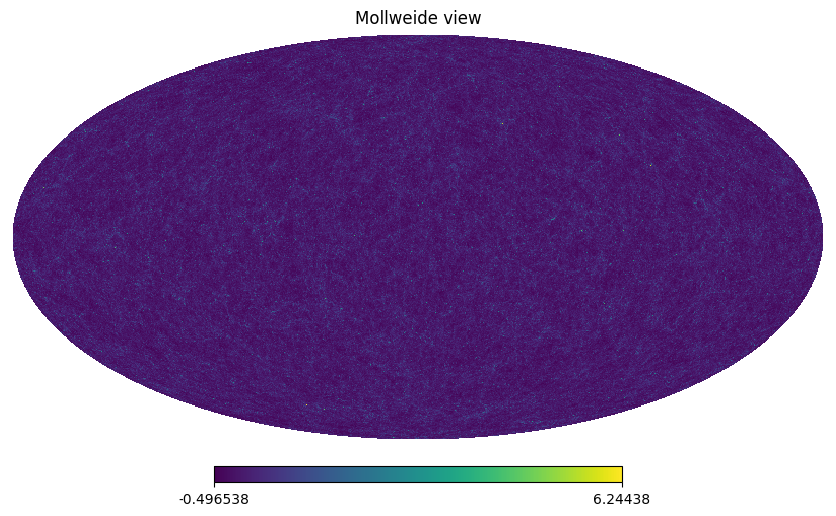

In [5]:
dg_original = (dg - np.mean(dg))/np.mean(dg)
dg_original = dg_original[:,0]
cls_original = hp.anafast(dg_original)

hp.mollview(dg_original)

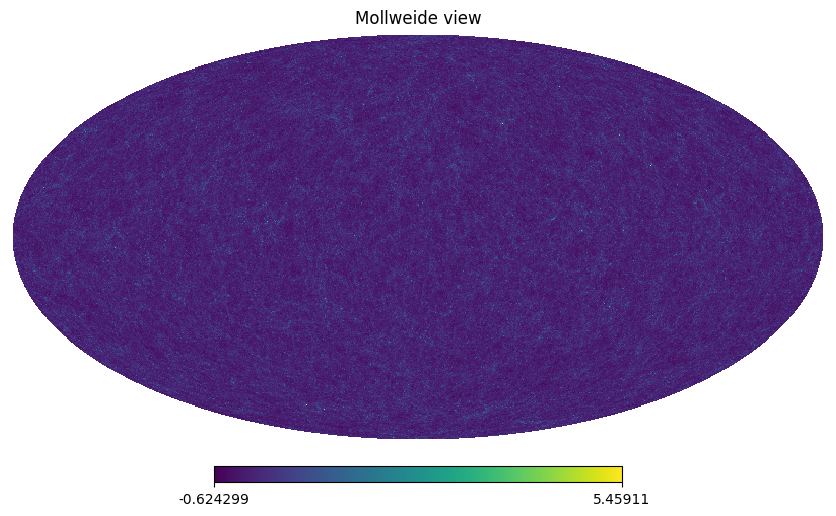

In [6]:
alm = hp.map2alm(dg_original, pol=False, use_pixel_weights=True, datapath=hp_datapath)

# draw random phases
stochasticity = 0.1
random_phases = stochasticity * rng.uniform(-np.pi, np.pi, alm.shape[0])
scrambled_alm = np.exp(1j * random_phases) * alm

dg_stoch = hp.alm2map(scrambled_alm, nside=n_side, pol=False)
cls_stoch = hp.anafast(dg_stoch)

hp.mollview(dg_stoch)

[None]

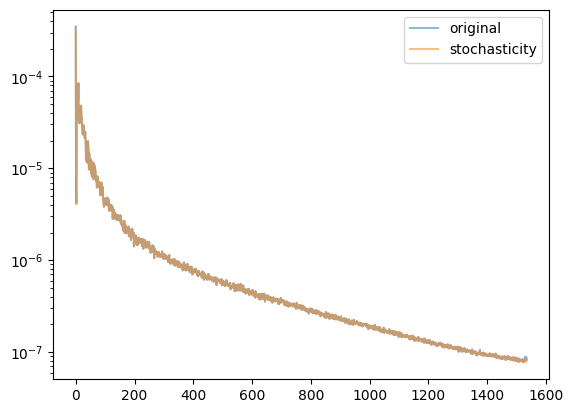

In [7]:
fig, ax = plt.subplots()

ax.plot(cls_original, label="original", alpha=0.5)
ax.plot(cls_stoch, label="stochasticity", alpha=0.5)

ax.legend()
ax.set(yscale="log")

[Text(0.5, 0, 'stochasticity parameter'),
 Text(0, 0.5, 'correlation coefficient')]

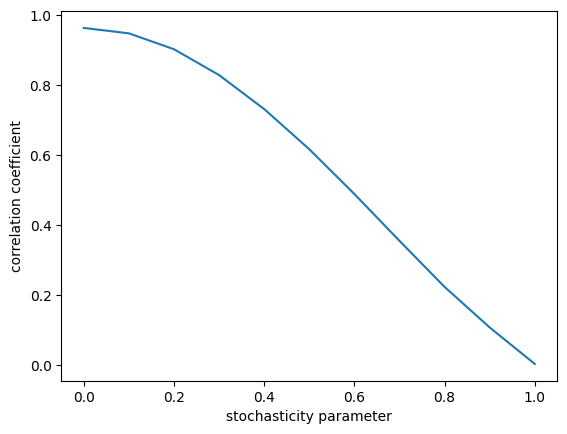

In [8]:
alm = hp.map2alm(dg_original, pol=False, use_pixel_weights=True, datapath=hp_datapath)

stochasticities = np.linspace(0, 1, 11)
correlations = []
for stochasticity in stochasticities:
    random_phases = stochasticity * rng.uniform(-np.pi, np.pi, alm.shape[0])
    scrambled_alm = np.exp(1j * random_phases) * alm
    dg_stoch = hp.alm2map(scrambled_alm, nside=n_side, pol=False)
    
    correlations.append(np.corrcoef(dg_original, dg_stoch)[0,1])
    
fig, ax = plt.subplots()

ax.plot(stochasticities, correlations)
ax.set(xlabel="stochasticity parameter", ylabel="correlation coefficient")

[Text(0, 0.5, 'stochasticity parameter'),
 Text(0.5, 0, 'correlation coefficient')]

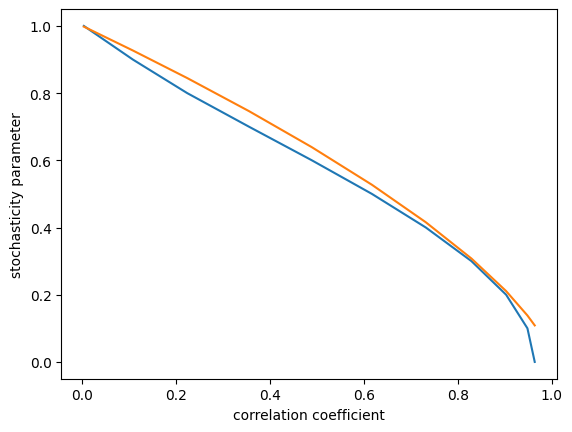

In [9]:
fig, ax = plt.subplots()

ax.plot(correlations, stochasticities)
ax.plot(correlations, (1-np.array(correlations))**(2/3))
ax.set(ylabel="stochasticity parameter", xlabel="correlation coefficient")

# from .tfrecords

In [10]:
tfr_pattern = "/pscratch/sd/a/athomsen/v11desy3/v10/linear_bias/tfrecords/grid/DESy3_grid_dmb_0000.tfrecord"

grid_pipe = GridPipeline(
    conf=conf,
    with_lensing=False,
    with_clustering=True,
    with_padding=True,
    apply_norm=False,
    return_maps=True,
)

grid_dset = grid_pipe.get_dset(
    tfr_pattern="/pscratch/sd/a/athomsen/v11desy3/v10/linear_bias/tfrecords/grid/DESy3_grid_dmb_0000.tfrecord",
    noise_indices=1,
    local_batch_size=1,
    n_readers=1,
    n_prefetch=0,
    is_eval=True,
)

for dv, cl, cosmo, index in tqdm(grid_dset.take(1)):
    pass


24-09-25 03:12:03     files.py INF   Loaded the pixel file /global/u2/a/athomsen/multiprobe-simulation-forward-model/data/DESY3_pixels_v11_fiducial_512.h5 
24-09-25 03:12:03     files.py INF   Loaded the pixel file /global/u2/a/athomsen/multiprobe-simulation-forward-model/data/DESY3_pixels_v11_fiducial_512.h5 
24-09-25 03:12:04 grid_pipelin INF   n_workers is not set, using tf.data.AUTOTUNE. This might produce unexpected RAM usage. 
24-09-25 03:12:04 grid_pipelin INF   drop_remainder is not set, using drop_remainder = False 
24-09-25 03:12:04 grid_pipelin INF   Including noise_indices = [0] 
24-09-25 03:12:04 grid_pipelin INF   Interleaving with n_readers = 1 
dict_keys(['cosmo', 'i_sobol', 'i_example', 'dg', 'cl'])
24-09-25 03:12:05 grid_pipelin INF   Batching into 1 elements locally 
24-09-25 03:12:06 grid_pipelin WAR   Tracing _augmentations 
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach

1it [00:04,  4.66s/it]


In [11]:
dv_original = np.zeros(n_pix)
dv_original[data_vec_pix] = dv[0,:,0]
dv_original = hp.reorder(dv_original, n2r=True)
alm_original = hp.map2alm(dv_original, pol=False, use_pixel_weights=True, datapath=hp_datapath)

[Text(0.5, 0, 'stochasticity parameter'),
 Text(0, 0.5, 'correlation coefficient')]

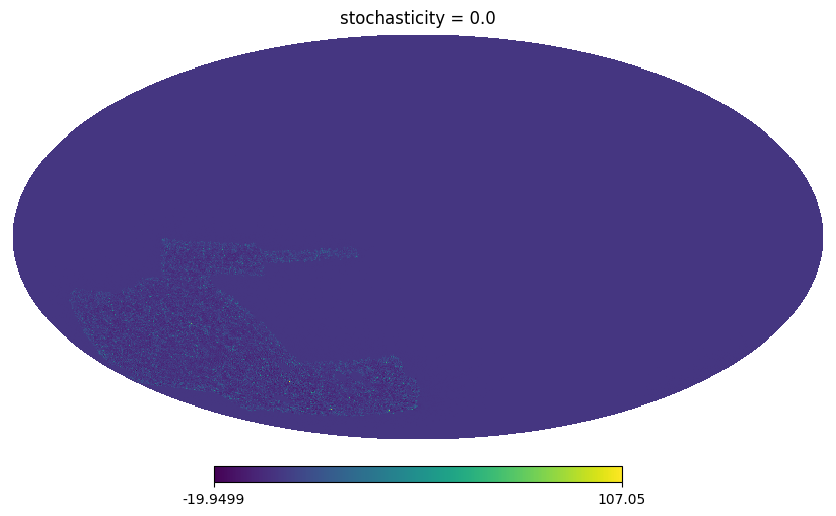

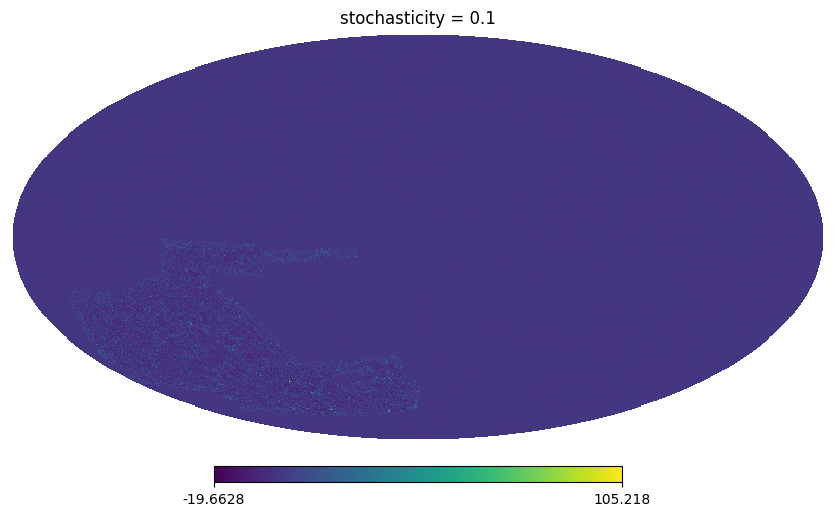

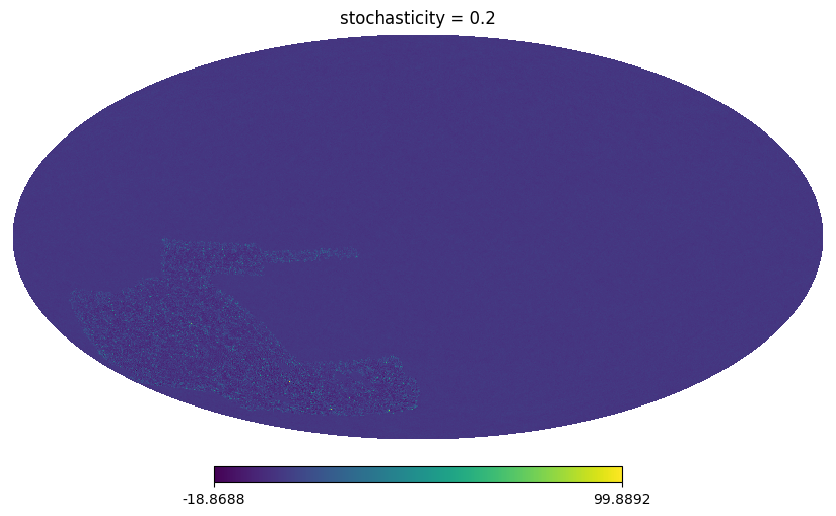

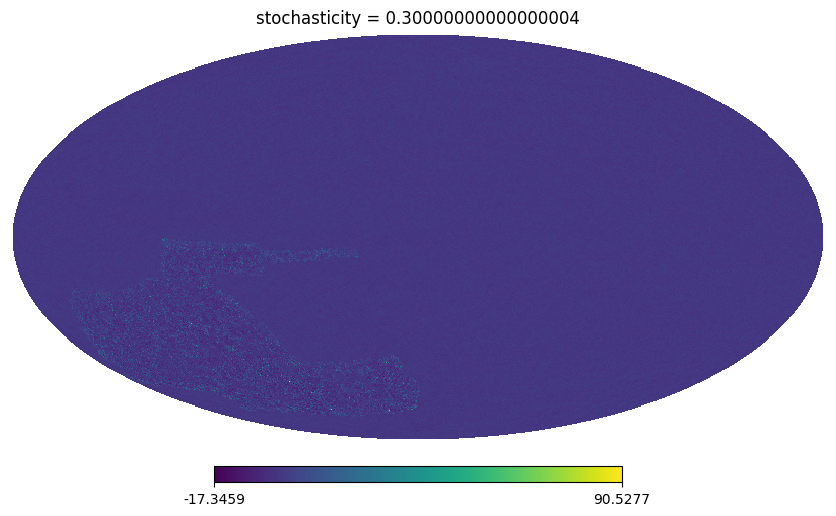

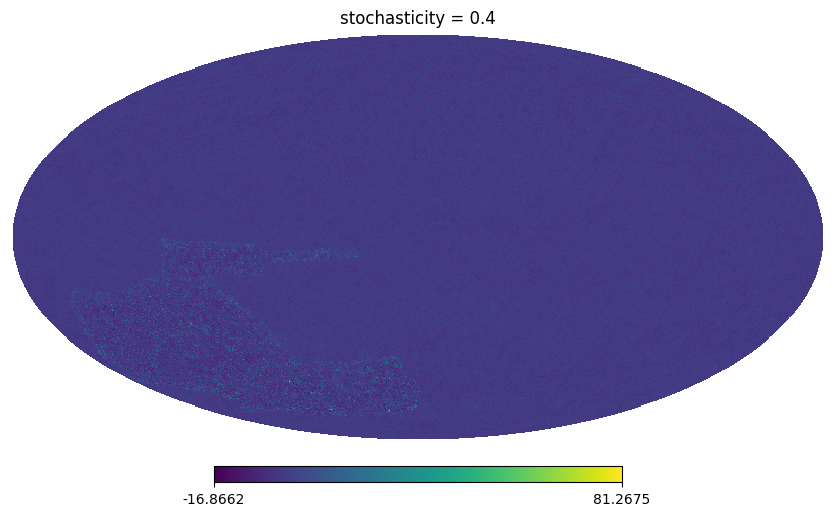

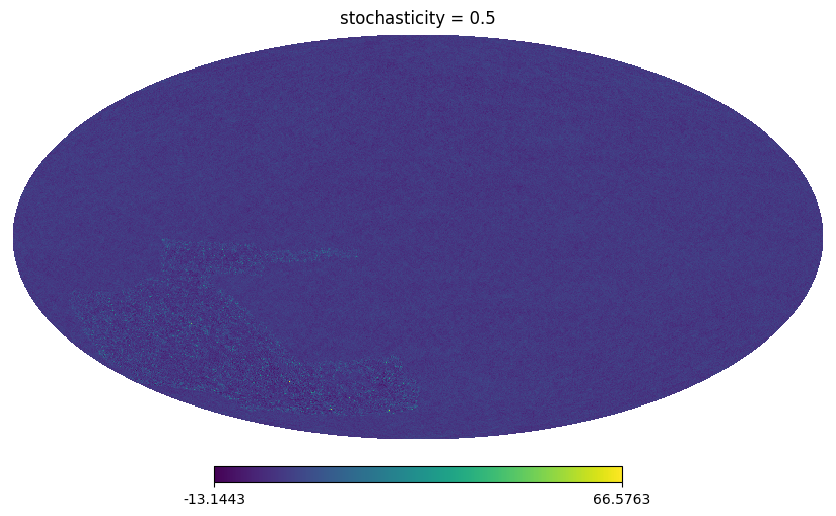

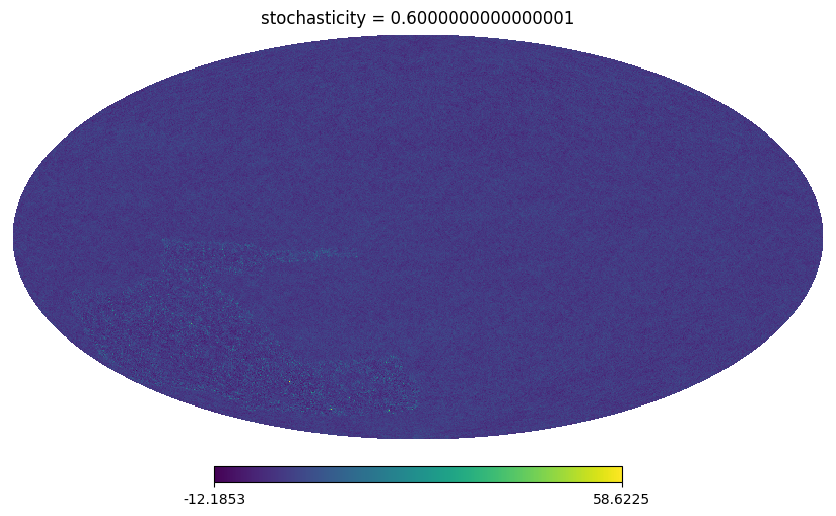

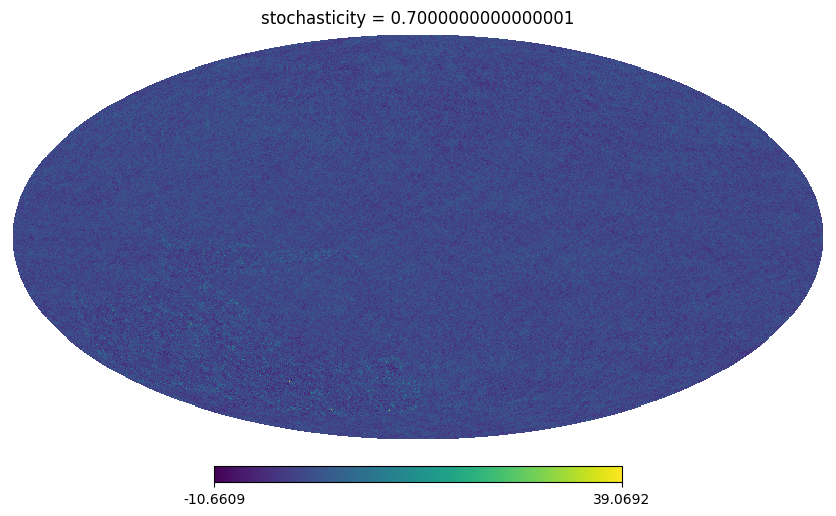

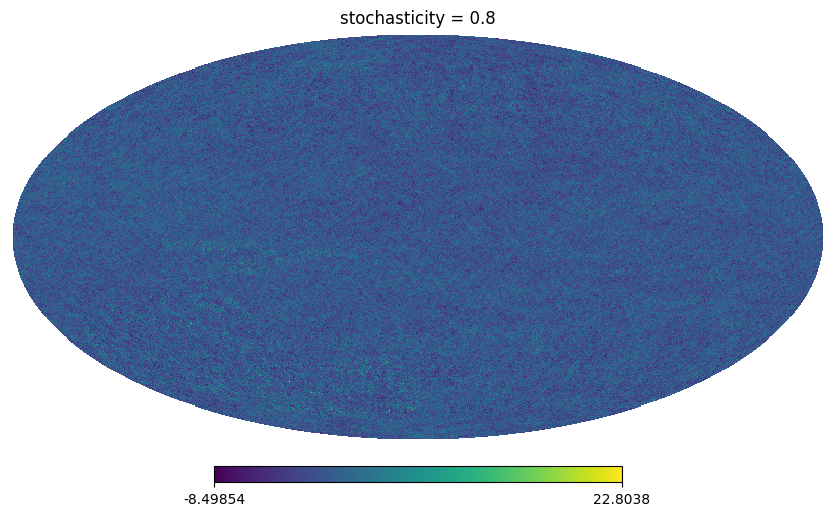

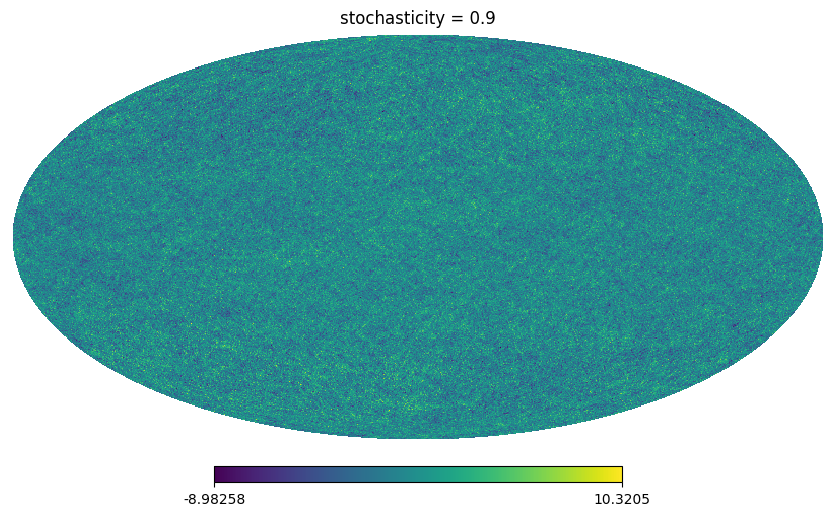

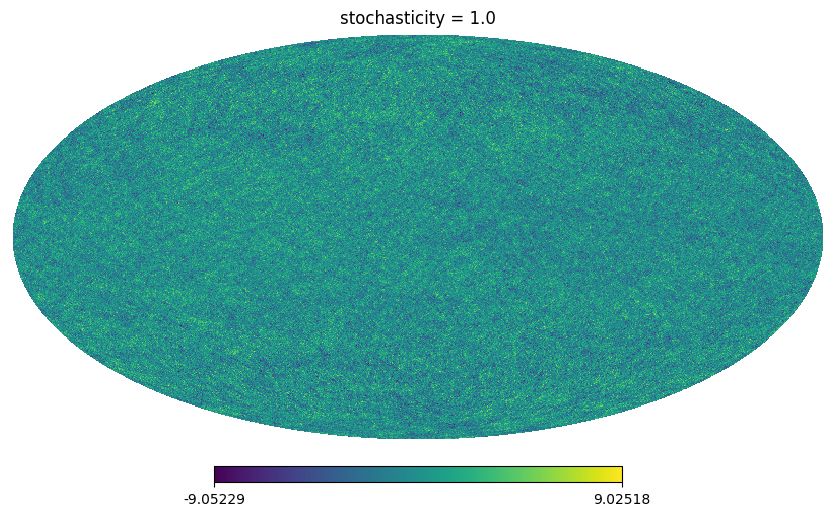

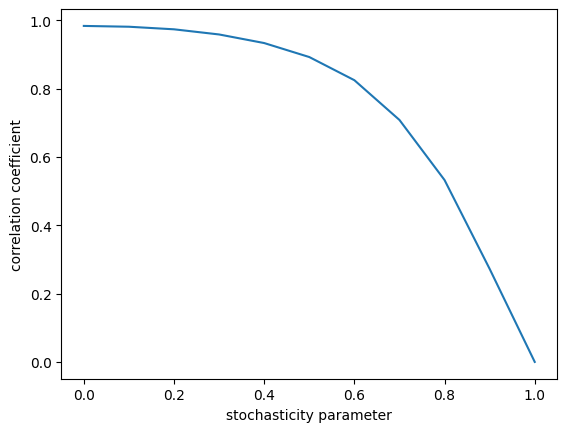

In [12]:
stochasticities = np.linspace(0, 1, 11)
correlations = []
for stochasticity in stochasticities:
    random_phases = stochasticity * rng.uniform(-np.pi, np.pi, alm_original.shape[0])
    scrambled_alm = np.exp(1j * random_phases) * alm_original
    dv_stoch = hp.alm2map(scrambled_alm, nside=n_side, pol=False)
    hp.mollview(dv_stoch, title=f"stochasticity = {stochasticity}")
        
    correlations.append(
        np.corrcoef(
            hp.reorder(dv_original, r2n=True)[data_vec_pix], 
            hp.reorder(dv_stoch, r2n=True)[data_vec_pix]
        )[0,1]
    )
    # correlations.append(np.corrcoef(dv_original, dv_stoch)[0,1])

fig, ax = plt.subplots()

ax.plot(stochasticities, correlations)
ax.set(xlabel="stochasticity parameter", ylabel="correlation coefficient")

[Text(0, 0.5, 'stochasticity parameter'),
 Text(0.5, 0, 'correlation coefficient')]

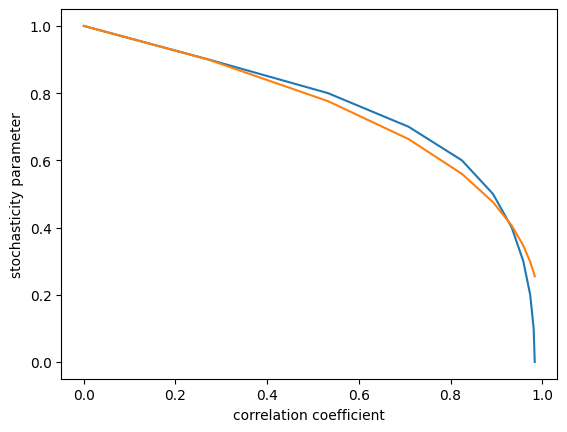

In [13]:
fig, ax = plt.subplots()

ax.plot(correlations, stochasticities)
ax.plot(correlations, (1-np.array(correlations))**(1/3))
ax.set(ylabel="stochasticity parameter", xlabel="correlation coefficient")